# Imports

Import python libraries as well as the self written FERMI library.

In [2]:
!pip install --user pyFAI

  Using cached pyFAI-0.20.0-cp39-cp39-manylinux2014_x86_64.whl (19.9 MB)
  Using cached silx-0.15.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.8 MB)
  Using cached fabio-0.12.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.8 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import sys, os
USER = os.environ['USER']

sys.path.append('./FERMI_2020-07/')
sys.path.append(f'/net/phase/store/users/{USER}/.local/lib/python3.9/site-packages')

import numpy as np
import xarray as xr
import pandas as pd
import h5py
from os.path import join, split
from glob import glob
from time import strftime
from imageio import imread

from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from pyFAI.detectors import Detector
from pyFAI.calibrant import Cell, Calibrant

from scipy.ndimage.filters import median_filter 



import matplotlib.pyplot as plt
from matplotlib.image import NonUniformImage
import process_FERMI_2021 as pf

from tqdm.auto import tqdm

from importlib import reload
from copy import deepcopy

In [2]:
#interactive plotting
%matplotlib widget

In [3]:
def plot_image(im, fname):
    fig, ax = plt.subplots(tight_layout=True)
    m = ax.imshow(im)
    plt.colorbar(m)
    ax.grid(False)
    fig.savefig(fname, dpi=100)
    plt.close(fig)

def plot_ai(df, time, samplefolder, scanfolder, fname):
    fig, ax = plt.subplots(tight_layout=True)
    az2d.plot.imshow(ax = ax, cmap = 'viridis')
    ax.set_title(f'{samplefolder} / {scanfolder}: delay %.2fps'%time)
    fig.savefig(fname, dpi=100)
    plt.close(fig)

def plot_curve(xdata, ydata, fname, xlabel = '', ylabel = ''):
    fig, ax = plt.subplots(tight_layout=True)
    ax.plot(xdata, ydata, 'o-')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.savefig(fname, dpi=100)
    plt.close(fig)

In [4]:
filters = {'Al-780 (3)': .34*.85,} #775nm of pure Al, 5nm of Al2O3

# load non-image data

Specify the folder of the run you want to analyze. No need to have the exact folder of the HDF files. The function *get_exp_dataframe* works recursively and gets all HDF files into the pandas DataFrame. It will also already take specific values that you can specify in *extra_keays* and save them into the same DataFrame.

In [5]:
basefolder = f'/net/phase/store/users/{USER}/20209130/'
samplefolder = 'results/usr/testdata/'
scanfolder = 'C4_Scan014'

datafolder = join(basefolder, samplefolder, scanfolder)
extra_keys = {
    'diode_sum': 'PAM/FQPDSum',
    'IR': 'Laser/Energy1',
    'magnet': 'Lecroy/Wave3',
    'bunches': 'bunches',
    'time': '',
}

exp = pf.get_exp_dataframe(datafolder, keys=extra_keys)
for k in ['xgm_UH', 'xgm_SH', 'diode_sum']:
    exp[k + '_sum'] = exp[k].apply(np.sum)

exp['diode_sum_mean'] = exp.diode_sum.apply(np.mean)
exp['diode_sum_std'] = exp.diode_sum.apply(np.std)
exp['IR_mean'] = exp.IR.apply(np.mean)
exp['IR_std'] = exp.IR.apply(np.std)
exp['magnet_mean'] = exp.magnet.apply(np.mean)
exp['magnet_mean'] = exp.magnet_mean.apply(np.round, args=(3,))
exp['bunchid'] = exp.bunches.apply(lambda l: l[-1])

exp = exp.sort_values('delay')

Let's have a look at it

In [6]:
exp

,filename,time,xgm_UH,xgm_SH,filter_EH_in,filter_UH_in,wavelength,diode_I0,diode_sum,polarization,...,bunches,xgm_UH_sum,xgm_SH_sum,diode_sum_sum,diode_sum_mean,diode_sum_std,IR_mean,IR_std,magnet_mean,bunchid
0,/net/phase/store/users/mschneid/20209130/resul...,1.594020e+09,"[41.69225046341064, 44.42697967503092, 40.9794...","[40.96034433424256, 43.784108562050655, 40.203...",Al-780 (3),Passthrough (1),20.8,"[38.350868225097656, 41.92829132080078, 36.023...","[160.13946533203125, 174.65858459472656, 148.8...",3.0,...,"[657773895, 657773896, 657773897, 657773898, 6...",12189.811142,11958.793161,46240.074921,154.133583,25.285242,17.261367,0.097791,2.213,657774194
39,/net/phase/store/users/mschneid/20209130/resul...,1.594022e+09,"[45.659107479174295, 32.752324836446924, 44.48...","[44.43839430327183, 32.16948077716861, 43.6449...",Al-780 (3),Passthrough (1),20.8,"[44.41051483154297, 29.652786254882812, 42.189...","[168.6847686767578, 127.42080688476562, 178.13...",3.0,...,"[657881871, 657881872, 657881873, 657881874, 6...",11481.090797,11250.099565,47396.454620,157.988182,30.095028,17.257633,0.095767,2.204,657882170
1,/net/phase/store/users/mschneid/20209130/resul...,1.594020e+09,"[42.706264433184245, 38.57744494293732, 33.713...","[41.42402953276111, 37.67385742955712, 32.7960...",Al-780 (3),Passthrough (1),20.8,"[40.24772644042969, 34.65843200683594, 30.3274...","[168.6298370361328, 146.6949462890625, 129.734...",3.0,...,"[657776943, 657776944, 657776945, 657776946, 6...",9331.876730,9073.711605,32106.393814,107.021313,46.320861,17.263667,0.087943,2.208,657777242
2,/net/phase/store/users/mschneid/20209130/resul...,1.594020e+09,"[43.456007049848026, 41.339966396893026, 40.39...","[41.75991283083343, 39.910063065226026, 38.860...",Al-780 (3),Passthrough (1),20.8,"[41.03565216064453, 38.10710906982422, 37.4462...","[170.70350646972656, 158.2683563232422, 155.58...",3.0,...,"[657781442, 657781443, 657781444, 657781445, 6...",9850.531391,9604.809380,35177.875900,117.259586,36.048954,17.281100,0.085024,2.207,657781741
3,/net/phase/store/users/mschneid/20209130/resul...,1.594020e+09,"[40.47665924860218, 43.96479718767017, 28.7518...","[38.51293386741381, 42.10514577339761, 27.5576...",Al-780 (3),Passthrough (1),20.8,"[35.18543243408203, 39.13536071777344, 27.8366...","[145.04356384277344, 162.5152587890625, 116.01...",3.0,...,"[657783202, 657783203, 657783204, 657783205, 6...",10966.668671,10731.149569,42170.938110,140.569794,25.071611,17.259433,0.093559,2.211,657783501
4,/net/phase/store/users/mschneid/20209130/resul...,1.594020e+09,"[39.97099896830177, 27.653483878295713, 38.470...","[38.6945269530242, 26.93570088053199, 37.47341...",Al-780 (3),Passthrough (1),20.8,"[35.44635772705078, 24.207687377929688, 32.292...","[150.03204345703125, 105.10482788085938, 121.9...",3.0,...,"[657784860, 657784861, 657784862, 657784863, 6...",11211.029538,10868.726150,44430.108261,148.100361,30.145105,17.242033,0.092420,2.210,657785159
5,/net/phase/store/users/mschneid/20209130/resul...,1.594020e+09,"[33.682078172504156, 41.36399036097309, 41.578...","[32.834769472873894, 40.53362000258792, 40.555...",Al-780 (3),Passthrough (1),20.8,"[33.57524871826172, 39.20917510986328, 39.8838...","[143.26515197753906, 166.28150939941406, 170.6...",3.0,...,"[657786480, 657786481, 657786482, 657786483, 6...",11206.841059,10935.744869,45827.160645,152.757202,29.480753,17.269600,0.084938,2.214,657786779
6,/net/phase/store/users/mschneid/20209130/resul...,1.594020e+09,"[26.060679656128546, 30.724041678576825, 4.730...","[25.214254352146597, 29.6469048047358, 4.40986...",Al-780 (3),Passthrough (1),20.8,"[25.702857971191406, 31.31275177001953, 6.2793...","[109.08393859863281, 116.94602966308594, 27.29...",3.0,...,"[657788196, 657788197, 657788198, 657788199, 6...",11340.284921,10983.816026,45726.378250,152.421261,29.705465,17.271833,0.083608,2.210,657788495
7,/net/phase/store/users/mschneid/20209130/resul...,1.594020e+09,"[40.334201420013066, 34.86568854110497, 35.561.

## load dark

### Background

In [29]:
exp_bg = pf.get_exp_dataframe(datafolder + '_BG', keys=extra_keys)
exp_bg['bunchid'] = exp.bunches.apply(lambda l: l[-1])
exp_bg = exp_bg.sort_values('time')

In [30]:
darkfolder = datafolder + '_BG'
darks = []
dflist = glob(darkfolder + '/**/*h5', recursive=True)
print(f'found {len(dflist)} files')
for f in dflist:
    _dark = pf.loadh5(f)[0]
    darks.append(_dark)
dark = np.mean(darks, axis = 0).astype(float)

found 4 files


### Only FEL images

In [31]:
exp_of = pf.get_exp_dataframe(datafolder + '_OF', keys=extra_keys)
for k in ['xgm_UH', 'xgm_SH', 'diode_sum']:
    exp_of[k + '_sum'] = exp_of[k].apply(np.sum)
exp_of['bunchid'] = exp.bunches.apply(lambda l: l[-1])
exp_of = exp_of.sort_values('time')

In [32]:
felfolder = datafolder + '_OF'
fels = []
felflist = exp_of.filename
print(f'found {len(felflist)} files')
ct = 0
for index, r in exp_of.iterrows():
    if ct <len(dflist):
        _fel = pf.loadh5(r['filename'])[0] - dark
        fels.append(deepcopy(_fel/r['diode_sum_sum']))
    else:
        break
fel = np.mean(fels[:-1], axis = 0).astype(float)

found 5 files


# Plot single image

Load an image and it's meta data. This will be used to setup the azimuthal integrator.

In [33]:
im, meta = pf.loadh5(exp.iloc[6]['filename'], extra_keys=['alignz', 'PAM/FQPDSum'])
im = im - dark
im2, meta2 = pf.loadh5(exp.iloc[-1]['filename'], extra_keys=['alignz', 'PAM/FQPDSum'])
im2 = im2 - dark

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
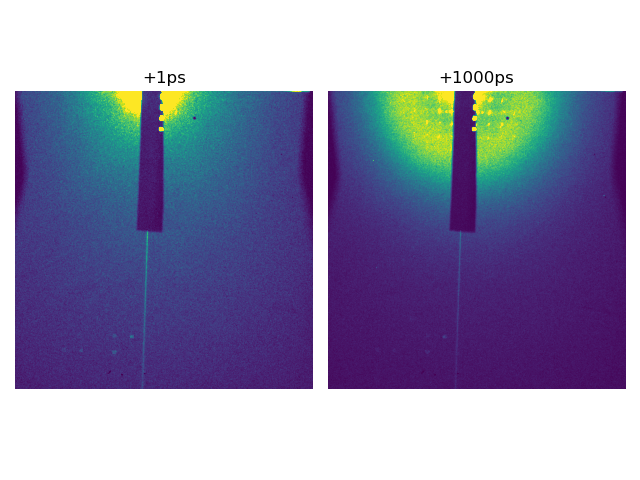

In [34]:
fig, ax = plt.subplots(1,2, sharex = True, sharey = True)
mi, ma = np.percentile(im, (1,99))
ax[0].imshow(im, vmin = mi, vmax = ma)
ax[0].set_axis_off()
ax[0].set_title('+1ps')
mi, ma = np.percentile(im2, (1,99))
ax[1].imshow(im2, vmin = mi, vmax = ma)
ax[1].set_axis_off()
ax[1].set_title('+1000ps')
fig.tight_layout()

# Mask

The masks are created by hand by Kathinka using GIMP and loaded into the masks image folder. Please check if the binarization worked correctly (Kathinka will probably forget if she used white for 1 and black for 0 or the other way around...

In [18]:
mask_manual = imread('/home/gerlinger/Documents/Beamtimes/2020-06_FERMI/Masks/CoPt_noAl_C4.png')[..., 0]
# mask_manual = imread('../images/masks/CoPtnoAl_B4Scan007_mask.png')[..., 0]
mask_manual = mask_manual > 0

In [20]:
center = [0, 470]  # off-set, binned
# center = [0, 950]  # off-set, full chip
# center = [1000, 950]

rmin = 160

beamstop = None

mask = pf.make_mask(im2 * mask_manual, center, rmin, beamstop=beamstop)
mask *= mask_manual

mask_nan = np.where(mask == 0, np.nan, 1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [37]:
# plt.imsave('/home/gerlinger/Dokumente/Beamtimes/2020-06_FERMI/Masks/CoPt_50nmAl_C6_im.png', im3 * mask_nan, vmin = mi, vmax = ma)

# Set up the azimuthal integration
This has to be done only once (unless the image center shifts, or the image shape changes).
Reusing the AzimuthalIntegrator instance is very fast.

You need to specifiy the center (determine it via the plotted image above). The rest is filled in automatically from the image shape and image meta data. 

In [21]:
detector = Detector(2 * 13.5e-6, 2 * 13.5e-6)  # binned!
ai = AzimuthalIntegrator(dist=(exp['ccdz'][0] + 33) / 1000,
                         rot2=-np.deg2rad(exp['ccd_rot'][0]),
                         poni2=470 * 13.5e-6 * 2,
                         poni1=390 * 13.5e-6 * 2,
                         detector=detector,
                         wavelength=exp['wavelength'][0] * 1e-9)

test it on our single image

In [23]:
I_t, q_t, phi_t = ai.integrate2d(im2, 200, unit='q_nm^-1', mask = (1-mask).astype(bool), correctSolidAngle=False)
az2d = xr.DataArray(I_t, dims = ('phi', 'q'), coords = {'q':q_t, 'phi': phi_t})
fig, ax = plt.subplots()
az2d.plot.imshow(ax = ax)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [25]:
q, I = ai.integrate1d(im2, 200, unit='q_nm^-1', mask = (1-mask).astype(bool), correctSolidAngle = False)

fig, ax = plt.subplots()
ax.plot(q, I)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Process delay scan
set up empty DataArray using xarray 

Now, all images are loaded and processed. The azimutal integration is saved in the scan xarray. If you see strange things happening in your results plot, set *debug_plots* to **True**. This will save all images in the scan into our tmp folder and you can take a look at them.

In [26]:
if not os.path.exists(f'/home/gerlinger/Documents/Beamtimes/2020-06_FERMI/Processed/{samplefolder}/{scanfolder}/'):
    os.mkdir(f'/home/gerlinger/Documents/Beamtimes/2020-06_FERMI/Processed/{samplefolder}/{scanfolder}/')

In [28]:
reload(pf)

<module 'process_FERMI_2021' from './FERMI_2020-07/process_FERMI_2021.py'>

In [29]:
scan = xr.DataArray(
    np.zeros([len(exp), len(q)]),
    dims=['delay', 'q'],
    coords={'q': q, 'delay': np.sort(exp.delay)}
)

scan_plot = xr.DataArray(
    np.zeros([len(exp), len(q)]),
    dims=['delay', 'q'],
    coords={'q': q, 'delay': np.sort(exp.delay)}
)

mean_im = []

debug_plots = False
folder_save = f'/home/gerlinger/Documents/Beamtimes/2020-06_FERMI/Processed/{samplefolder}/{scanfolder}/azimutal_integration/'

norm_key = 'diode_sum_sum'

expmean = np.mean(exp[norm_key])
expstd = np.std(exp[norm_key])

plt.ioff()
for index, r in tqdm(exp.iterrows()):
    exp_bg['sort_delay'] = np.abs(exp_bg['delay'] - r['delay'])
    idx = np.where(exp_bg['sort_delay'] == np.min(exp_bg['sort_delay']))[0][0]
    ct = 0
    while np.abs(exp_of.iloc[idx][norm_key] - expmean) > 2 * expstd:
        ct +=1
        print("%i: Normalization of OF not okay."%idx)
        if idx == 3:
            idx -= 1
        else:
            idx += 1
            
        if ct >= 4:
            break
            
    # Load image files
    darkfile = exp_bg.iloc[idx]['filename']
    dark = pf.loadh5(darkfile)[0].astype(int)
    felfile = exp_of.iloc[idx]['filename']
    fel = pf.load_image_diodenorm(felfile, dark, normkey = 'PAM/FQPDSum')
    im = pf.load_image_diodenorm(r['filename'], dark, normkey = 'PAM/FQPDSum')
    im = im - fel
    
    if debug_plots:
        if not os.path.exists(folder_save):
            os.mkdir(folder_save)
        I_t, q_t, phi_t = ai.integrate2d(im, 200, unit='q_nm^-1', mask = (1-mask).astype(bool), correctSolidAngle = False)
        az2d = xr.DataArray(I_t, dims = ('phi', 'q'), coords = {'q':q_t, 'phi': phi_t})
        plot_ai(az2d, 6.67 * r['delay'] - 137.3, samplefolder, scanfolder, folder_save + '%.2f.png'%(6.67 * r['delay'] - 137.3))
        
    _, I = ai.integrate1d(im, 200, unit='q_nm^-1', mask = (1-mask).astype(bool), correctSolidAngle = False)
    scan.loc[{'delay': r['delay']}] = I
    if np.abs(r[norm_key] - expmean) < 2 * expstd:
        scan_plot.loc[{'delay': r['delay']}] = I
    else:
        scan_plot.loc[{'delay': r['delay']}] = np.nan
        print('%.1f ps: Skipped because the diode signal is too small.'%(6.67 * r['delay'] - 137.3))

plt.ion()
scan = scan.groupby('delay').mean()
scan_plot = scan_plot.groupby('delay').mean()
scan_plot = scan_plot.dropna('delay')

0: Normalization of OF not okay.
1: Normalization of OF not okay.
0: Normalization of OF not okay.
1: Normalization of OF not okay.
0: Normalization of OF not okay.
1: Normalization of OF not okay.
1: Normalization of OF not okay.
1: Normalization of OF not okay.
1: Normalization of OF not okay.
1: Normalization of OF not okay.
1: Normalization of OF not okay.
1: Normalization of OF not okay.
1: Normalization of OF not okay.
1: Normalization of OF not okay.
1: Normalization of OF not okay.
1: Normalization of OF not okay.
1: Normalization of OF not okay.
1: Normalization of OF not okay.
1: Normalization of OF not okay.
1: Normalization of OF not okay.
90.2 ps: Skipped because the diode signal is too small.



## plot

In [31]:
t0 = 137.3
scan['delay_ps'] = 6.67 * scan['delay'] - t0
scan_plot['delay_ps'] = 6.67 * scan_plot['delay'] - t0
try:
    scan = scan.swap_dims({'delay': 'delay_ps'})
    scan_plot = scan_plot.swap_dims({'delay': 'delay_ps'})
    print('Swapped Dimensions')
except Exception:
    print('Something went wrong.')
    pass

Swapped Dimensions


In [32]:
qmin, qmax = 0.0, np.max(scan.q)

demag = scan.where((scan['q'] > qmin) & (scan['q'] < qmax)).sum('q')
demag_plot = scan_plot.where((scan_plot['q'] > qmin) & (scan_plot['q'] < qmax)).sum('q')

qmean = scan.where((scan['q'] > qmin) & (scan['q'] < qmax)).mean('q')

In [40]:
ir = int(np.round(np.mean(exp['IR_mean'])))
fig, ax = plt.subplots(nrows=2, ncols = 1, figsize=(7, 4.5), sharex=True, tight_layout=True)
vmin, vmax = float(scan_plot.min()), float(scan_plot.max())
scan_plot.plot.contourf(x='delay_ps', y='q', ax=ax[0], cmap='viridis', add_colorbar=False,
                   vmin=vmin, vmax=vmax, levels=30)
ax[1].plot(demag_plot.delay_ps, demag_plot, 'o-')
ax[1].grid()

fig.suptitle(f'{samplefolder} / {scanfolder}: IR {ir} mJ/cm²')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0.98, 'CoPt_noAl / C4_Scan019: IR 17 mJ/cm²')

In [93]:
plt.close('all')

In [123]:
if not os.path.exists(f'/home/gerlinger/Documents/Beamtimes/2020-06_FERMI/Processed/{samplefolder}/{scanfolder}/'):
    os.mkdir(f'/home/gerlinger/Documents/Beamtimes/2020-06_FERMI/Processed/{samplefolder}/{scanfolder}/')

exp.to_hdf(f'/home/gerlinger/Documents/Beamtimes/2020-06_FERMI/Processed/{samplefolder}/{scanfolder}/{scanfolder}.h5', key = 'Exp_Data')
scan.to_netcdf(f'/home/gerlinger/Documents/Beamtimes/2020-06_FERMI/Processed/{samplefolder}/{scanfolder}/{scanfolder}_Scan.h5')
scan_plot.to_netcdf(f'/home/gerlinger/Documents/Beamtimes/2020-06_FERMI/Processed/{samplefolder}/{scanfolder}/{scanfolder}_Scan-plot.h5')
demag.to_netcdf(f'/home/gerlinger/Documents/Beamtimes/2020-06_FERMI/Processed/{samplefolder}/{scanfolder}/{scanfolder}_Demag.h5')
demag_plot.to_netcdf(f'/home/gerlinger/Documents/Beamtimes/2020-06_FERMI/Processed/{samplefolder}/{scanfolder}/{scanfolder}_Demag-plot.h5')

/home/gerlinger/miniconda3/lib/python3.8/site-packages/pandas/core/generic.py:2431: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['filename', 'xgm_UH', 'xgm_SH', 'filter_EH_in', 'filter_UH_in',
       'diode_I0', 'diode_sum', 'IR', 'valve_pos2', 'valve_dpi3', 'comment',
       'magnet', 'bunches'],
      dtype='object')]

  pytables.to_hdf(


## 1ns and final state

In [124]:
t = 0
for f in exp_of['filename']:
    if os.path.getmtime(f) > t:
        t = os.path.getmtime(f)
        felfile = f
        
print(felfile)

/home/gerlinger/Documents/Beamtimes/2020-06_FERMI/Data/CoPt_noAl/C4_Scan019_OF/rawdata/C4_Scan019_OF_658458482.h5


In [126]:
darkfile = exp_bg.iloc[idx]['filename']
dark = pf.loadh5(darkfile)[0].astype(int)
offile = exp_of.iloc[idx]['filename']
of = (pf.loadh5(offile)[0].astype(int) - dark) / exp_of.iloc[idx][norm_key]
# of = of - np.mean(of[-50:, 500:])

fel = (pf.loadh5(felfile)[0].astype(int) - dark) / exp_of.iloc[-1][norm_key] - of
# fel = fel - np.mean(fel[-50:, 500:])

_, I_fel = ai.integrate1d(fel, 200, unit='q_nm^-1', mask = (1-mask).astype(bool), correctSolidAngle=False)
I = scanb.sel(delay_ps=1e3, method='nearest')

In [127]:
mi, ma = np.percentile(fel * mask, (1, 99))
fig, ax = plt.subplots()
mm = ax.imshow(fel, vmin = mi, vmax = ma)
plt.colorbar(mm)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [128]:
fig, ax = plt.subplots()
# ax.set_yscale('log')
ax.plot(scan.q, I_fel, '-', label = 'final')
ax.plot(scan.q, scan.sel(delay_ps=1000, method='nearest'), '-', label = '1000 ps')
ax.plot(scan.q, scan.sel(delay_ps=100, method='nearest'), '-', label = '100 ps')
#ax.plot(scan.q, I_fel, '-', label = 'final state')
ax.set_xlabel(r'q (nm$^{-1}$)')
ax.set_ylabel('Intensity (a.u.)')
ax.set_title(f'{samplefolder} / {scanfolder}')

# ax.set_ylim(top = 6e-4)
ax.legend()
ax.grid()
fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [129]:
df = pd.DataFrame({'q': scan.q, 'I': I_fel})
df.to_hdf(f'/home/gerlinger/Documents/Beamtimes/2020-06_FERMI/Processed/{samplefolder}/{scanfolder}/{scanfolder}_final-state.h5', key = 'Intensity')

In [178]:
plt.close('all')

In [53]:
fig, ax = plt.subplots()
ax.plot(scan.q, I_of - I_before, '-', label = 'difference OF - initial scattering')
ax.set_xlabel('q')
ax.set_ylabel('Intensity (a.u.)')
ax.set_title(f'{samplefolder} / {scanfolder}')
ax.legend()
ax.grid()
fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Misc

## Azimutal Integration for specific images

In [ ]:
imagelist = {
    '5258.h5': 2.5,
    '1426.h5': 5,
    #'0249.h5': 7.5,
    '5428.h5': 10,
    #'3233.h5': 12.5,
    '3233.h5': 15,
    '6571.h5': 17.5,
    '8033.h5': 20,
}

In [ ]:
filtered = pf.filtering(f'{basefolder}{samplefolder}/', list(k for k in imagelist.keys()))
filtered = [f for f in filtered if 'C4' in f]

In [ ]:
sortf = np.array([filtered[0]] * len(filtered))
imarray = np.array(list(k for k in imagelist.keys()))
for file in filtered:
    idx = np.where(imarray == file[-7:])[0][0]
    sortf[idx] = deepcopy(file)

In [ ]:
az_int = []
images = []
for f in sortf:
    im, meta = pf.loadh5(f, extra_keys={'diode_sum': 'PAM/FQPDSum',})
    im = (im - dark.astype(float))/ np.sum(meta['diode_sum'])
    im -= (np.mean(im[-50:, 500:]) + before)
    images.append(im)
    q, I = ai.integrate1d(im * mask, 200, unit='q_nm^-1')
    az_int.append(I / norm)
integrated = xr.DataArray(az_int, dims=['labels', 'q'], coords = {'q': q})
images = np.array(images)

In [ ]:
integrated[-2].to_netcdf(f'/home/gerlinger/Documents/Beamtimes/2020-06_FERMI/Processed/{samplefolder}/{scanfolder}/{scanfolder}_final-state.h5')
I_fel = integrated[-2]

In [ ]:
label = np.round(np.array([ 2.08208978,  4.16417957,  6.24626935,  8.32835914, 10.41044892, 12.4925387 , 14.57462849, 16.65671827]), decimals = 1)
blues = ['#edf8b1', '#c7e9b4', '#7fcdbb', '#41b6c4', '#1d91c0', '#225ea8', '#253494', '#081d58']
# plot, instead of the file endings you can also define a label list and iterate through that list
fig, ax = plt.subplots()
ct = 0
for data in integrated:
    ax.plot(integrated.q, data, blues[ct], label = f'{label[ct]} mJ/cm$^2$')
    ct += 1
plt.legend()
ax.set_xlabel('q (nm$^{-1}$)')
ax.set_ylabel('intensity (a.u.)')
ax.grid()
ax.set_title(f'{samplefolder} / {scanfolder}: Magnet %.1f A'%mag_max)
fig.tight_layout()

## Get magnet information

This is only done when doing a delay scan to check what the maximal magnet amperage was and at which amperage the FEL hit the sample.

Since this process should be identical for each delay, we only take the magnet info from the image that was plotted above.

Please check that the lower plateau was correctly found! If the orange curve is only 1 on these lower plateaus everything is fine. If not, please change the chunksize (the numbers of points over which the slope is calculated) or the maximum slope. The default values, also here as default in the template, are *chunksize = 500, max_slope = 4e-7*.

In [419]:
def get_magnet(fname, offset = .2, plot = True, chunksize = 500, max_slope = 4e-7):
    scan = split(split(split(fname)[0])[0])[-1]
    sample = split(split(split(split(fname)[0])[0])[0])[-1]
    with h5py.File(fname, 'r') as f:
        magnet = f['Lecroy/Wave3'][()]
    mag_mean = np.mean(magnet, axis = 0) + offset
    mag_lower = np.mean(mag_mean[np.where(pf.zero_slope(mag_mean, 500) == 1)])
    mag_upper = np.max(mag_mean)
    if plot:
        sname = split(fname)[-1]
        fig, ax = plt.subplots()
        ax.plot(mag_mean, label = 'mean')
        ax.plot(pf.zero_slope(mag_mean, chunksize, max_slope), label = 'magnet change')
        ax.grid()
        ax.set_xlabel('time (a.u.)')
        ax.set_ylabel('magnet current (A)')
        ax.legend()
        ax.set_title(f'{sample}/{scan}' + ': max = %.1f, min = %.1f'%(mag_upper, mag_lower)) #include max and min of magnet current in title
        #fig.savefig(f'../images/Magnet/{sname}.png')
    return (magnet, mag_lower, mag_upper)

In [414]:
dd = np.float(scan.sel(delay_ps=40, method='nearest').delay)

In [420]:
magnet, mag_min, mag_max = get_magnet(exp.loc[exp.delay == dd]['filename'].values[0], offset = .3,
                                 chunksize = 500, max_slope = 4e-7, plot = True) #exp.iloc[0]['filename']

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'zero_slope' is not defined